In [ ]:
import pandas as pd
import tensorflow as tf
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, backend as K
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Multiply, Subtract, Lambda, Input, Embedding, Dense, Activation, Lambda, Permute,Flatten, Concatenate, Dropout, GlobalAveragePooling1D, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Reshape, Dot
from tensorflow.keras.activations import softmax
import itertools
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from tokenization_bert import BertTokenizer
from sklearn.metrics import ndcg_score
import pickle, inspect
import os
from ast import literal_eval
import torch
import re, math
import random
from random import sample
from torch.autograd import Variable
import glob
from collections import Counter
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.layers import Embedding
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import average_precision_score
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
from itertools import combinations
import modeling_bert
from modeling_utils import (PretrainedConfig, PreTrainedModel)
from graph_encoder import GNNRelationModel, pool
import re
import unicodedata
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
maxSeqLn = 50
num_label = 4

In [3]:
def remove_bracketed_text(text):
    # Remove text enclosed in brackets using regular expressions
    cleaned_text = re.sub(r'\([^)]*\)', '', text)
    return cleaned_text

def clean(text):
    # Remove non-ASCII characters using the unicodedata module
    text = text.lower()
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')
    text = remove_bracketed_text(text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\s+(\,)', r'\1', text)
    cleaned_text = re.sub(r'\s+(\.)', r'\1', text)
    return cleaned_text

In [4]:
dftrain = pd.read_csv("train.csv", header=None)
dftest = pd.read_csv("test.csv", header=None)
dfval = pd.read_csv("val.csv", header=None)

In [5]:
print(len(dftrain))
print(len(dftest))
print(len(dfval))

11611
3871
3870


In [6]:
def find(sup, sub):
    for i,s1 in enumerate(sup):
        if ((len(s1) - len(sub[0])) * (len(s1) - len(sub[0])) <= 4) and (s1 in sub[0] or sub[0] in s1):
            lsb = len(sub)
            lsp = len(sup)
            flag = True
            for j in range(lsb):
                if i+j < lsp and (sub[j] in sup[i+j] or sup[i+j] in sub[j]) and ((len(sub[j]) - len(sup[i+j])) * (len(sup[i+j]) - len(sub[j])) <= 4):
                    continue
                else:
                    flag = False
                    break
            if flag == True:
                return i
    return -1


def mark_a_sentence(sent, first_entity, second_entity):
    sent = sent.lower()
    first_entity = first_entity.lower()
    second_entity = second_entity.lower()
    entity1_tokens = first_entity.split()
    entity2_tokens = second_entity.split()
    sent_toks = sent.split()
    labels = ['1'] * len(sent_toks)
    i = find(sent_toks, entity1_tokens)
    if i > -1:
        for j in range(i, i+len(entity1_tokens)):
            labels[j] = '2'

    i = find(sent_toks, entity2_tokens)
    if i > -1:
        for j in range(i, i+len(entity2_tokens)):
            labels[j] = '3'
    return labels

first_entity = 'alvand'
second_entity = 'the zagros mountain'
sen = 'alvand is a subrange of the zagros mountains in western iran located south of the city of hamedan in hamedan province.'
print(mark_a_sentence(sen, first_entity, second_entity))

['2', '1', '1', '1', '1', '3', '3', '3', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


In [7]:
first_entity = '30 st mary axe'
second_entity = 'skyscraper'
sen = 'london''s skyscrapers, such as 30 st mary axe, tower 42, the broadgate tower and one canada square, are mostly in the two financial districts, the city of london and canary wharf'
print(find(sen.split(), second_entity.split()))

print(sen.split())
print(second_entity.split()) 

1
['londons', 'skyscrapers,', 'such', 'as', '30', 'st', 'mary', 'axe,', 'tower', '42,', 'the', 'broadgate', 'tower', 'and', 'one', 'canada', 'square,', 'are', 'mostly', 'in', 'the', 'two', 'financial', 'districts,', 'the', 'city', 'of', 'london', 'and', 'canary', 'wharf']
['skyscraper']


In [8]:
vals = []
for v in dftrain.values:
    st = v[2] 
    tokens = st.split()
    labels = ['1'] * len(tokens)
    first = v[0]
    second = v[1]
    if v[3] == False:
        vals.append([v[0], v[1], v[2], labels, v[3]])
    else:
        vals.append([v[0], v[1], v[2], mark_a_sentence(v[2], v[0], v[1]), v[3]])
        

dftrain2 = pd.DataFrame(data=vals, index=None,columns=None)

In [9]:
vals = []
for v in dftest.values:
    st = v[2] 
    tokens = st.split()
    labels = ['1'] * len(tokens)
    first = v[0]
    second = v[1]
    if v[3] == False:
        vals.append([v[0], v[1], v[2], labels, v[3]])
    else:
        vals.append([v[0], v[1], v[2], mark_a_sentence(v[2], v[0], v[1]), v[3]])
        

dftest2 = pd.DataFrame(data=vals, index=None,columns=None)

In [10]:
vals = []
for v in dfval.values:
    st = v[2] 
    tokens = st.split()
    labels = ['1'] * len(tokens)
    first = v[0]
    second = v[1]
    if v[3] == False:
        vals.append([v[0], v[1], v[2], labels, v[3]])
    else:
        vals.append([v[0], v[1], v[2], mark_a_sentence(v[2], v[0], v[1]), v[3]])
        

dfval2 = pd.DataFrame(data=vals, index=None,columns=None)

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained('bert-uncased')

In [12]:
print(tokenizer.tokenize('ami valo chele'))

['ami', 'val', '##o', 'che', '##le']


In [13]:
unique_labels = ['1', '2', '3']
labels_to_ids = {k: v+1 for v, k in enumerate(unique_labels)}
ids_to_labels = {v+1: k for v, k in enumerate(unique_labels)}
print(labels_to_ids)
print(unique_labels)

{'1': 1, '2': 2, '3': 3}
['1', '2', '3']


In [14]:
vals = pd.read_csv("causality_dataset.csv", header=None).values[:,3]

In [15]:
#pos_tags = []
#for v in vals:
#    tuples = v.split('|||')
#    for t in tuples:
#        pos_tags.append(literal_eval(t)[2])
#        
#unique_pos_tags = list(set(pos_tags))

In [16]:
unique_pos_tags_dict = {'ADP' : 1, 'SYM':2, 'INTJ':3, 'SCONJ':4, 'PRON':5, 'PUNCT':6, 'AUX':7, 'PROPN':8, 'CCONJ':9, 'NUM':10, 'X':11, 'ADJ':12, 'VERB':13, 'PART':14, 'ADV':15, 'SPACE':16, 'NOUN':17, 'DET':18}

In [17]:
print(unique_pos_tags_dict)

{'ADP': 1, 'SYM': 2, 'INTJ': 3, 'SCONJ': 4, 'PRON': 5, 'PUNCT': 6, 'AUX': 7, 'PROPN': 8, 'CCONJ': 9, 'NUM': 10, 'X': 11, 'ADJ': 12, 'VERB': 13, 'PART': 14, 'ADV': 15, 'SPACE': 16, 'NOUN': 17, 'DET': 18}


In [18]:
#text = 'a high level of cholesterol in the blood leads to an increased risk of developing coronary heart disease.'
#dep = "('level', 'a', 'DET')|||('level', 'high', 'ADJ')|||('leads', 'level', 'NOUN')|||('level', 'of', 'ADP')|||('of', 'cholesterol', 'NOUN')|||('level', 'in', 'ADP')|||('blood', 'the', 'DET')|||('in', 'blood', 'NOUN')|||('leads', 'leads', 'VERB')|||('leads', 'to', 'ADP')|||('risk', 'an', 'DET')|||('risk', 'increased', 'VERB')|||('to', 'risk', 'NOUN')|||('risk', 'of', 'ADP')|||('of', 'developing', 'VERB')|||('disease', 'coronary', 'ADJ')|||('disease', 'heart', 'NOUN')|||('developing', 'disease', 'NOUN')|||('leads', '.', 'PUNCT')"

#align_pos_tag(text, dep)

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-uncased')

In [20]:
def find_sublist_indices(super_list, sublist):
    indices = []
    sublist_length = len(sublist)
    for i in range(len(super_list) - sublist_length + 1):
        if super_list[i:i+sublist_length] == sublist:
            indices.extend(list(range(i, i+sublist_length)))
    return indices

In [21]:
#super_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#sublist = [3, 4, 5]

#indices = find_sublist_indices(super_list, sublist)
#print(indices) [2,3,4]

In [22]:
n_tr = len(dftrain)
train_matrix = np.zeros((n_tr, maxSeqLn, maxSeqLn))

for k,val in enumerate(tqdm(dftrain.values)):
    dependencies = [literal_eval(v) for v in val[-1].split('|||')]
    #print(dependencies)
    bert_tokens = tokenizer.convert_ids_to_tokens(tokenizer.batch_encode_plus([val[-2]])['input_ids'][0])
    #print(bert_tokens)
    for dep in dependencies:
        v1 = tokenizer.tokenize(dep[0])
        v2 = tokenizer.tokenize(dep[1])
        i_s = find_sublist_indices(bert_tokens, v1)
        j_s = find_sublist_indices(bert_tokens, v2)
        for i in i_s:
            for j in j_s:
                train_matrix[k][i][j] = 1.0
    for i in range(maxSeqLn-1):
        train_matrix[k][i][i+1] = 1.0
        train_matrix[k][i+1][i] = 1.0

100%|██████████| 11611/11611 [00:17<00:00, 670.25it/s]


In [23]:
n_vl = len(dfval)
dev_matrix = np.zeros((n_vl, maxSeqLn, maxSeqLn))

for k,val in enumerate(tqdm(dfval.values)):
    dependencies = [literal_eval(v) for v in val[-1].split('|||')]
    #print(dependencies)
    bert_tokens = tokenizer.convert_ids_to_tokens(tokenizer.batch_encode_plus([val[-2]])['input_ids'][0])
    #print(bert_tokens)
    for dep in dependencies:
        v1 = tokenizer.tokenize(dep[0])
        v2 = tokenizer.tokenize(dep[1])
        i_s = find_sublist_indices(bert_tokens, v1)
        j_s = find_sublist_indices(bert_tokens, v2)
        for i in i_s:
            for j in j_s:
                dev_matrix[k][i][j] = 1.0
    for i in range(maxSeqLn-1):
        dev_matrix[k][i][i+1] = 1.0
        dev_matrix[k][i+1][i] = 1.0

100%|██████████| 3870/3870 [00:05<00:00, 651.10it/s]


In [24]:
n_test = len(dftest)
test_matrix = np.zeros((n_test, maxSeqLn, maxSeqLn))

for k,val in enumerate(tqdm(dftest.values)):
    dependencies = [literal_eval(v) for v in val[-1].split('|||')]
    #print(dependencies)
    bert_tokens = tokenizer.convert_ids_to_tokens(tokenizer.batch_encode_plus([val[-2]])['input_ids'][0])
    #print(bert_tokens)
    for dep in dependencies:
        v1 = tokenizer.tokenize(dep[0])
        v2 = tokenizer.tokenize(dep[1])
        i_s = find_sublist_indices(bert_tokens, v1)
        j_s = find_sublist_indices(bert_tokens, v2)
        for i in i_s:
            for j in j_s:
                test_matrix[k][i][j] = 1.0
    for i in range(maxSeqLn-1):
        test_matrix[k][i][i+1] = 1.0
        test_matrix[k][i+1][i] = 1.0

100%|██████████| 3871/3871 [00:05<00:00, 663.02it/s]


In [25]:
label_all_tokens = False


def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=maxSeqLn, truncation=True)
    
    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(0)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(0)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else 0)
            except:
                label_ids.append(0)
        previous_word_idx = word_idx
        
    assert len(set(label_ids)) <= 4
    assert len(label_ids) == maxSeqLn

    return label_ids

def align_pos_tag(text, dependency):
    tokenized_inputs = tokenizer(text, padding='max_length', max_length=maxSeqLn, truncation=True)
    
    spacy_tokens = [literal_eval(t)[1] for t in dependency.split('|||')]
    spacy_pos_tags = [literal_eval(t)[2] for t in dependency.split('|||')]
    
    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    pos_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            pos_ids.append(0)

        elif word_idx != previous_word_idx:
            try:
                pos_ids.append(unique_pos_tags_dict[spacy_pos_tags[word_idx]])
            except:
                pos_ids.append(0)
        else:
            try:
                pos_ids.append(unique_pos_tags_dict[spacy_pos_tags[word_idx]] if label_all_tokens else 0)
            except:
                pos_ids.append(0)
        previous_word_idx = word_idx
        
        
    assert len(set(pos_ids)) <= 30
    assert len(pos_ids) == maxSeqLn

    return pos_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df, matrix):

        lb = [i for i in df.values[:,3].tolist()]
        txt = [i for i in df.values[:,2].tolist()]
        deps = [i for i in df.values[:,4].tolist()]
        
        self.texts = txt
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]
        self.dependencies = deps
        self.matrix = matrix
        
    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])
    
    def get_batch_matrix(self, idx):

        return torch.LongTensor(self.matrix[idx])
    
    def get_dependencies(self, idx):

        return self.dependencies[idx]

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)
        batch_deps = self.get_dependencies(idx)
        batch_matrix = torch.LongTensor(self.get_batch_matrix(idx))

        return batch_data, batch_labels, batch_deps, batch_matrix

In [26]:
class BertAttention(nn.Module):
    def __init__(self):
        super(BertAttention, self).__init__()
        self.output = modeling_bert.BertSelfOutput()
        self.attn = BertSelfAttention()
        self.pruned_heads = set()

    def forward(self, input_tensor, z, attention_mask):
        self_outputs = self.attn(input_tensor,
                                 z,
                                 attention_mask)
        attention_output = self.output(self_outputs[0],
                                       input_tensor)
        outputs = (attention_output,) + self_outputs[1:]
        return outputs

In [27]:
bert = AutoModel.from_pretrained('bert-uncased')
import inspect
inspect.getfullargspec(bert.forward)

FullArgSpec(args=['self', 'input_ids', 'attention_mask', 'token_type_ids', 'position_ids', 'head_mask', 'inputs_embeds', 'encoder_hidden_states', 'encoder_attention_mask', 'past_key_values', 'use_cache', 'output_attentions', 'output_hidden_states', 'return_dict'], varargs=None, varkw=None, defaults=(None, None, None, None, None, None, None, None, None, None, None, None, None), kwonlyargs=[], kwonlydefaults=None, annotations={})

In [28]:
#AutoTokenizer.from_pretrained('/home/mkabir/my_pretrained_model/ebert')
class MyTokenizer:
    def __init__(self):
        self.tok = AutoTokenizer.from_pretrained('bert-uncased')
        
    def new_batch_encode_plus(self, texts, dependencies):
        encoded = self.tok.batch_encode_plus(texts, max_length=maxSeqLn, truncation=True, return_tensors="pt", padding='max_length')
        encoded['tag_indices'] = torch.tensor([align_pos_tag(i,j) for i,j in zip(texts, dependencies)])
        return encoded

In [29]:
text = 'a high level of cholesterol in the blood leads to an increased risk of developing coronary heart disease.'
dep = "('level', 'a', 'DET')|||('level', 'high', 'ADJ')|||('leads', 'level', 'NOUN')|||('level', 'of', 'ADP')|||('of', 'cholesterol', 'NOUN')|||('level', 'in', 'ADP')|||('blood', 'the', 'DET')|||('in', 'blood', 'NOUN')|||('leads', 'leads', 'VERB')|||('leads', 'to', 'ADP')|||('risk', 'an', 'DET')|||('risk', 'increased', 'VERB')|||('to', 'risk', 'NOUN')|||('risk', 'of', 'ADP')|||('of', 'developing', 'VERB')|||('disease', 'coronary', 'ADJ')|||('disease', 'heart', 'NOUN')|||('developing', 'disease', 'NOUN')|||('leads', '.', 'PUNCT')"

tok = MyTokenizer()
print(tok.new_batch_encode_plus([text], [dep]))

{'input_ids': tensor([[  101,  1037,  2152,  2504,  1997, 16480,  4244, 27833,  1999,  1996,
          2668,  5260,  2000,  2019,  3445,  3891,  1997,  4975, 21887,  2854,
          2540,  4295,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'tag_indices': tensor([[ 0, 18, 12, 17,  1, 17,  0,  0,  1, 18, 17, 13,  1, 18, 13, 17,  1, 13,
         12,  0, 17, 17,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0

In [30]:
print(maxSeqLn)

50


In [31]:
class CombineBertModel(nn.Module):
    def __init__(self):
        super(CombineBertModel, self).__init__()
        self.syntax_encoder = GNNRelationModel().to(device)
        self.bert = modeling_bert.BertModel()
        self.original_bert = AutoModel.from_pretrained('bert-uncased')
        model_dict = self.bert.state_dict()
        pretrained_dict = {k: v for k, v in self.original_bert.state_dict().items() if k not in 'embeddings.token_type_embeddings.weight'}
        model_dict.update(pretrained_dict) 
        self.bert.load_state_dict(model_dict, strict=False)
        self.bert = self.bert.to(device)
        

    def postprocess_attention_mask(self, mask):
        mask = mask.to(dtype=next(self.parameters()).dtype) 
        mask = (1.0 - mask) * -10000.0
        return mask


    def forward(self, input_ids, tag_ids, token_mask, adj_matrix):

        sequence_output,_ = self.bert(input_ids=input_ids,attention_mask=token_mask,token_type_ids=tag_ids)

        sequence_output = self.syntax_encoder(sequence_output,adj_matrix,None,None)

        outputs = (sequence_output, None)
        return outputs

In [32]:
class MyTokenClassification(nn.Module):
    def __init__(self):
        super(MyTokenClassification, self).__init__()
        self.com_bert = CombineBertModel().to(device)
        self.tok = MyTokenizer()
        self.num_labels = 4
        self.classifier = nn.Linear(768,4).to(device)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, txts, dependencies, adj_matrix):
        query_tokenized = self.tok.new_batch_encode_plus(txts,dependencies).to(device)
        token_embedding, _ = self.com_bert(query_tokenized['input_ids'], query_tokenized['tag_indices'], query_tokenized['attention_mask'], adj_matrix)
        cls_vals = self.classifier(token_embedding)
        probs = self.softmax(cls_vals)
        return probs

In [33]:
train_dataset = DataSequence(dftrain2, train_matrix)
val_dataset = DataSequence(dfval2, dev_matrix)

In [34]:
train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=64)

In [35]:
from sklearn.metrics import precision_recall_fscore_support

In [36]:
def train_loop(model):
    
    criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.0,0.5,1.0,1.0])).to(device)
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
    tol = 3
    patience = 0

    best_acc = 0
    best_loss = 1000
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0
        precisions = []
        recalls = []
        f1_scores = []

        model.train()

        for train_text, train_label, tran_dep, adj_mat in tqdm(train_dataloader):
            
            train_text = list(train_text)
            train_label = train_label.to(device)
            tran_dep = list(tran_dep)
            train_batch_matrix = adj_mat.to(device)

            optimizer.zero_grad()
            logits = model(train_text, tran_dep, train_batch_matrix).to(device)
            batch_loss = criterion(logits.view(-1,num_label), train_label.view(-1))
            total_loss_train += batch_loss.item()

            for i in range(logits.shape[0]):

                logits_clean = logits[i][train_label[i] != 0]
                label_clean = train_label[i][train_label[i] != 0]
                
                logits_clean= logits_clean[:,1:]
                predictions = logits_clean.argmax(dim=1) + 1
                
                acc = (predictions == label_clean).float().mean()
                total_acc_train += acc
                total_loss_train += batch_loss.item()

            batch_loss.backward()
            optimizer.step()
            
        train_losses.append(total_loss_train)
        
        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_text, val_label, val_dep, adj_mat in val_dataloader:

            val_text = list(val_text)
            val_label = val_label.to(device)
            val_batch_matrix = adj_mat.to(device)

            logits = model(val_text, val_dep, val_batch_matrix).to(device)
            batch_loss = criterion(logits.view(-1,num_label), val_label.view(-1))

            for i in range(logits.shape[0]):

                logits_clean = logits[i][val_label[i] != 0]
                label_clean = val_label[i][val_label[i] != 0]

                logits_clean= logits_clean[:,1:]
                predictions = logits_clean.argmax(dim=1) + 1
                #prec, rec, fscore, _= precision_recall_fscore_support(label_clean.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='micro')

                #precisions.append(prec)
                #recalls.append(rec)
                #fscores.append(fscore)
                
                acc = (predictions == label_clean).float().mean()
                total_acc_val += acc
                total_loss_val += batch_loss.item()

        val_accuracy = total_acc_val / len(dfval)
        val_loss = total_loss_val / len(dfval)
        
        if val_accuracy >= best_acc:
            best_acc = val_accuracy
            #print(best_acc)
            patience = 0
            torch.save(model, "bert_pos_dep")
        else:
            patience = patience + 1
            
        val_losses.append(val_loss)
        
        pd.DataFrame(data=train_losses).to_csv("train_losses_bert_pos_dep.csv", header=None,columns=None,index=None)
        pd.DataFrame(data=val_losses).to_csv("val_losses_bert_pos_dep.csv", header=None,columns=None,index=None)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(dftrain): .3f} | Accuracy: {total_acc_train / len(dftrain): .3f} | Val_Loss: {total_loss_val / len(dfval) : .3f} | Val Accuracy: {total_acc_val / len(dfval): .3f}')
        
        if patience > tol:
            break


In [ ]:
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 64
model = MyTokenClassification().to(device)
train_loop(model)

100%|██████████| 182/182 [00:42<00:00,  4.29it/s]


Epochs: 1 | Loss:  1.007 | Accuracy:  0.829 | Val_Loss:  0.861 | Val Accuracy:  0.908


100%|██████████| 182/182 [00:42<00:00,  4.26it/s]


Epochs: 2 | Loss:  0.868 | Accuracy:  0.910 | Val_Loss:  0.833 | Val Accuracy:  0.926


100%|██████████| 182/182 [00:42<00:00,  4.28it/s]


Epochs: 3 | Loss:  0.846 | Accuracy:  0.926 | Val_Loss:  0.822 | Val Accuracy:  0.935


100%|██████████| 182/182 [00:42<00:00,  4.24it/s]


Epochs: 4 | Loss:  0.836 | Accuracy:  0.933 | Val_Loss:  0.817 | Val Accuracy:  0.938


100%|██████████| 182/182 [00:42<00:00,  4.26it/s]


Epochs: 5 | Loss:  0.831 | Accuracy:  0.936 | Val_Loss:  0.815 | Val Accuracy:  0.939


  9%|▉         | 16/182 [00:04<00:38,  4.33it/s]

In [ ]:
train_losses = pd.read_csv("train_losses_bert_pos_dep.csv").values
plt.plot(train_losses)

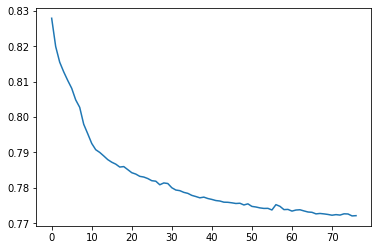

In [75]:
val_losses = pd.read_csv("val_losses_bert_pos_dep.csv").values
plt.plot(val_losses)

In [33]:
model = torch.load("bert_pos_dep")

In [37]:
test_dataset = DataSequence(dftest2, test_matrix)
test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=64)
total_acc_test = 0
precisions = []
recalls = []
fscores = []
exact_acc_ct = 0
total_count = 0
for test_text, test_label, test_dep, adj_mat in tqdm(test_dataloader):

    test_text = list(test_text)
    test_label = test_label.to(device)
    test_batch_matrix = adj_mat.to(device)
    logits = model(test_text, test_dep, test_batch_matrix).to(device)

    for i in range(logits.shape[0]):

        logits_clean = logits[i][test_label[i] != 0]
        label_clean = test_label[i][test_label[i] != 0]

        logits_clean= logits_clean[:,1:]
        predictions = logits_clean.argmax(dim=1) + 1
        prec, rec, fscore, _= precision_recall_fscore_support(label_clean.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='macro', zero_division = 1)

        precisions.append(prec)
        recalls.append(rec)
        fscores.append(fscore)

        acc = (predictions == label_clean).float().mean()
        if acc == 1:
            exact_acc_ct = exact_acc_ct + 1
        total_acc_test += acc
        total_count = total_count + 1

test_accuracy = total_acc_test / len(dftest2)
avg_prec = np.mean(precisions)
avg_rec = np.mean(recalls)
avg_fscores = np.mean(fscores)

print(test_accuracy)
print(avg_prec)
print(avg_rec)
print(avg_fscores)
print(exact_acc_ct / total_count)

100%|██████████| 61/61 [00:09<00:00,  6.49it/s]

tensor(0.9735, device='cuda:0')
0.9634316851184864
0.9622912157366779
0.9561336700714776
0.8584345130457246
